In [6]:
!pip freeze | grep cellpose

cellpose==2.1.1


In [42]:
import torch
print(torch.cuda.is_available())
from cellpose.models import CellposeModel, Cellpose
from os import path
import cellpose
import GPUtil
from aicsimageio import AICSImage
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
import yaml
from matplotlib import pyplot as plt
import zarr
from dask import array as da
from skimage import measure, filters
log_file=path.join("/tmp/cellpose_{jj}.log")
# cellpose.logger.handlers=[]
# cellpose.logger.addHandler(logging.FileHandler(log_file))
# cellpose.logger.addHandler(logging.StreamHandler(sys.stdout))

True


In [3]:
import sys
sys.path.append("/mnt/showers/AxioObserver7/ImageData/Fukai/image_analysis/230203_timelapse")
from utils import percentile_normalize

In [64]:
basedir = "/mnt/showers/AxioObserver7/ImageData/Fukai/2023-01-27-timelapse/"
workdir = "/work/fukai/2023-01-27-timelapse/"
file_path_frames = [
    ("/mnt/showers/AxioObserver7/ImageData/Fukai/2023-01-27-timelapse/2023-02-03/230203-atRA-nolive-stage-staining.czi",0,"nolive1"),
    ("/mnt/showers/AxioObserver7/ImageData/Fukai/2023-01-27-timelapse/2023-02-03/230203-atRA-live-staining.czi",0,"live"),
    ("/mnt/showers/AxioObserver7/ImageData/Fukai/2023-01-27-timelapse/2023-02-03/230203-atRA-nolive-staining.czi",0,"nolive2"),
    ("/mnt/showers/AxioObserver7/ImageData/Fukai/2023-01-27-timelapse/2023-02-03/230203-control-nolive-staining.czi",0,"control"),
    ("/mnt/showers/AxioObserver7/ImageData/Fukai/2023-01-27-timelapse/2023-01-30/230130-atRA-live-2.czi/230130-atRA-live-2_AcquisitionBlock1.czi/230130-atRA-live-2_AcquisitionBlock1_pt1.czi",100,"live-healthy")
]

# Run for all images

In [20]:
import ray
ray.init(num_cpus=30,ignore_reinit_error=True)


2023-02-16 09:40:12,013	INFO worker.py:1370 -- Calling ray.init() again after it has already been called.


Python version:,3.10.8
Ray version:,2.2.0


In [76]:
z=0
intensity_keys = ["intensity_max","intensity_min","intensity_mean"]

@ray.remote
def get_resionprops_res(m,mask,image):
    image2 = image[:,m,z]
    image2 = [filters.gaussian(im,2) for im in image2]
    image2 = np.moveaxis(image2 ,0,-1)
    return measure.regionprops_table(mask[m,z].compute(),image2,
                                     properties=["label","area"]+intensity_keys
                                     )
    
regionprops_dfs = []

for j, (file_path, frame, name) in enumerate(file_path_frames):
    print(j)
    zarr_path = path.join(workdir,path.relpath(file_path,basedir)+"_rescaled.zarr")
    image = da.from_zarr(zarr_path,component="image")
    mask = da.from_zarr(zarr_path,component="mask")
    metadata_path = path.join(workdir,path.relpath(file_path,basedir)+"_metadata.yaml")
    with open(metadata_path,"r") as f:
        channel_names = yaml.safe_load(f)["channel_names"]
    mask_id = ray.put(mask)
    image_id = ray.put(image)
    res = ray.get([get_resionprops_res.remote(m,mask_id,image_id) for m in range(image.shape[1])])
#    res = []
#    for m in range(image.shape[1]):
#        res.append(get_resionprops_res(m,mask,image))
    dfs = [pd.DataFrame(r) for r in res]
    for m in range(len(dfs)):
        dfs[m]["mosaic"] = m
    regionprops_df = pd.concat(dfs)

    key_maps = dict(sum(
    [[(f"{k}-{i}",f"{k}-{c}") for i,c in enumerate(channel_names)]
     for k in intensity_keys],[]))
    regionprops_df = regionprops_df.rename(columns=key_maps)
    regionprops_df["experiment_name"] = name
    regionprops_dfs.append(regionprops_df)
regionprops_df = pd.concat(regionprops_dfs)

0
1
2
3
4


In [91]:
name

'nolive2'

/home/fukai/.pyenv/versions/miniconda3-4.7.12/envs/cellpose/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


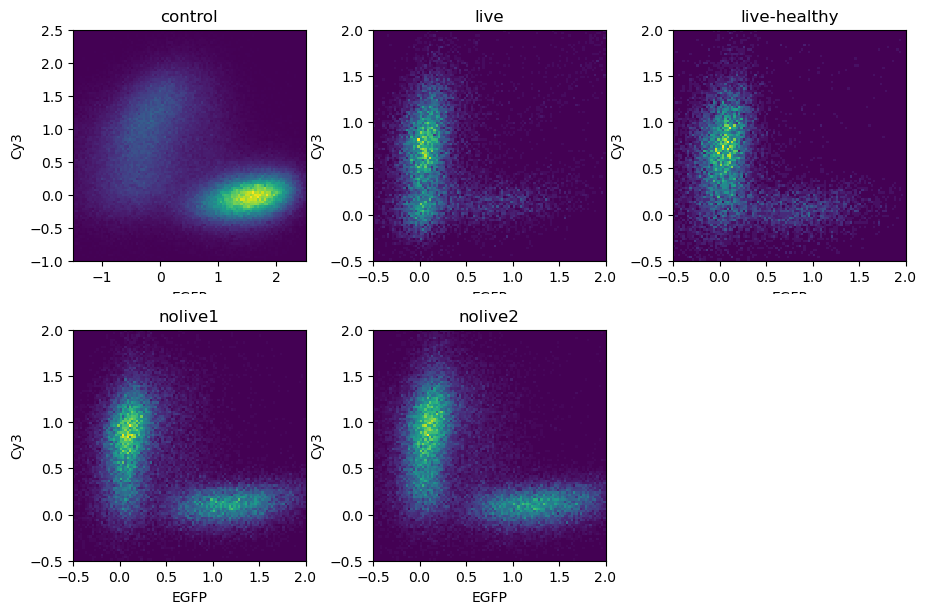

In [116]:
fig = plt.figure(figsize=(9,6))
figs = fig.subfigures(2,3,hspace=5.,wspace=5.,squeeze=False)
for _fig, (name, grp) in zip(
    np.ravel(figs),
    regionprops_df.groupby("experiment_name")):
    if name == "control":
        ranges=((-1.5,2.5),(-1.0,2.5))
    else:
        ranges=((-0.5,2.),(-0.5,2.))
    ax = _fig.subplots(1,1)
    ax.hist2d(np.log(grp["intensity_mean-EGFP"]+1),
            np.log(grp["intensity_mean-Cy3"]+1),bins=100,
            range=ranges)
    ax.set_title(name)
    ax.set_xlabel("EGFP")
    ax.set_ylabel("Cy3")
fig.show()

/home/fukai/.pyenv/versions/miniconda3-4.7.12/envs/cellpose/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


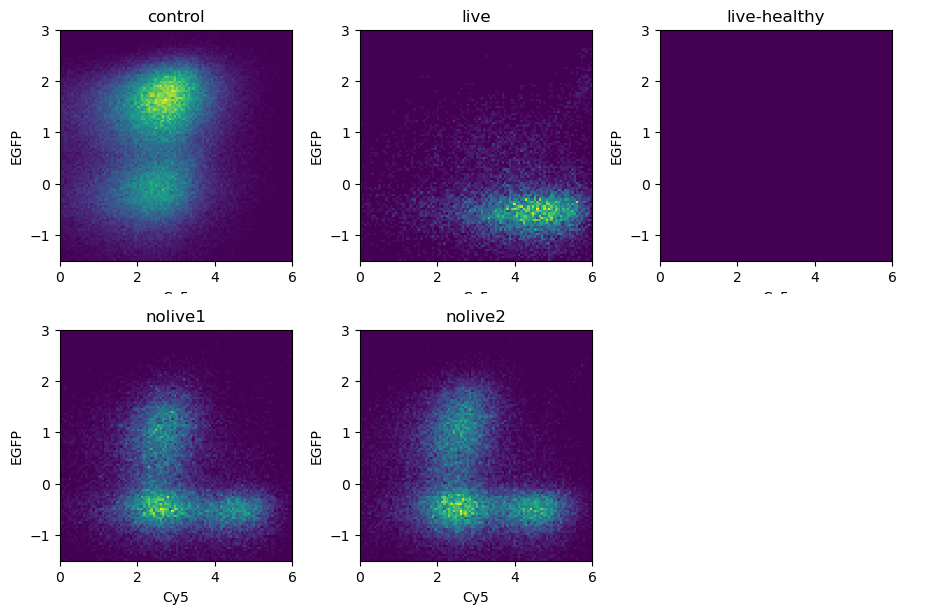

In [117]:
fig = plt.figure(figsize=(9,6))
figs = fig.subfigures(2,3)
for _fig, (name, grp) in zip(
    np.ravel(figs),
    regionprops_df.groupby("experiment_name")):
    if name == "control":
        ranges=((0,6),(-1.5,3))
        offset = 1
    else:
        ranges=((0,6),(-1.5,3))
        offset=0.5
    ax = _fig.subplots(1,1)
    ax.hist2d(np.log(grp["intensity_mean-Cy5"]+1),
            np.log(grp["intensity_mean-EGFP"]+offset),bins=100,
            range=ranges)
    ax.set_title(name)
    ax.set_ylabel("EGFP")
    ax.set_xlabel("Cy5")